<h1 id="oversampling_on_order_of_3rd_largest_class_for_multiclass_classification_of_accidents">Oversampling on the Order of the 3rd Largest Class for Multiclass Classification of Accident Severity in Seattle, Washington<\h1>

In [1]:
# Import packages and modules.
import io
import itertools
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import pandas as pd
import pylab as pl
import scipy
import scipy.optimize as opt
import seaborn as sns
import sklearn
import sys
import timeit
import warnings
from matplotlib.ticker import NullFormatter
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.sparse import csr_matrix
from sklearn import linear_model
from sklearn import metrics
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import svm
from sklearn import tree
from sklearn import utils
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import log_loss
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import r2_score
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.exceptions import ConvergenceWarning
from timeit import default_timer
%matplotlib inline

In [2]:
warnings.filterwarnings("ignore", category=ConvergenceWarning,
                        module="sklearn")

In [3]:
# Define the starting time for this notebook. 
notebook_start_time = default_timer()

In [4]:
# This function computes the time elapsed in seconds from the 
# time represented by the first parameter (start_time)
# to the time represented by the second parameter (end_time)
# This function requires the os package to be imported.
def elapsed_time(start_time = notebook_start_time):
    return default_timer() - start_time   

In [5]:
# This function prints the time elapsed in seconds from the 
# time represented by the first parameter (start_time)
# to the time represented by the second parameter (end_time)
# This function requires the os package to be imported.
def print_elapsed_time(start_time = notebook_start_time):
    print("Elapsed time is", elapsed_time(start_time), "seconds.")
    return None

In [6]:
# Create a list of display options.
list_of_display_options_fully_qualified_names = str(\
"pd.options.display.chop_threshold, pd.options.display.float_format, pd.options.display.max_info_columns, pd.options.display.notebook_repr_html, \
pd.options.display.colheader_justify, pd.options.display.html, pd.options.display.max_info_rows, pd.options.display.pprint_nest_depth, \
pd.options.display.column_space, pd.options.display.large_repr, pd.options.display.max_rows, pd.options.display.precision, \
pd.options.display.date_dayfirst, pd.options.display.latex, pd.options.display.max_seq_items, pd.options.display.show_dimensions, \
pd.options.display.date_yearfirst, pd.options.display.max_categories, pd.options.display.memory_usage, pd.options.display.unicode, \
pd.options.display.encoding, pd.options.display.max_columns, pd.options.display.min_rows, pd.options.display.width, \
pd.options.display.expand_frame_repr, pd.options.display.max_colwidth, pd.options.display.multi_sparse").split(sep=', ')

# Initialize an empty list to store all the short names for display options.
list_of_display_options_short_names = list()
# For each fully qualified option name,
# get the option's short name and add it to the list of short names.
for fully_qualified_option_name in list_of_display_options_fully_qualified_names:
    # Get short option name.
    short_option_name = fully_qualified_option_name.split(sep='.')[-1]
    
    # Add short option name to list of display option short names.
    list_of_display_options_short_names.append(short_option_name)

# Define dictionary of display option settings.
dict_of_display_option_settings_short_names=\
{"max_info_columns": 1000,\
"colheader_justify": "right",\
"max_info_rows": 1000000,\
"column_space": 1000,\
"max_rows": 1000000,\
"precision": 9,\
"max_seq_items": 1000000000000,\
"show_dimensions": True,\
"max_categories": 100,\
"memory_usage": True,\
"max_columns": 1000,\
"max_colwidth": 1000,\
"float_format": lambda x: '%.9f' % x}

# Set pandas display options using dictionary of short names,
# and display the options/value pairs.
print("Setting display options...")
for key in list(dict_of_display_option_settings_short_names.keys()):
    # Set display option.
    pd.set_option(key, dict_of_display_option_settings_short_names[key])
    # Print display option name and value.
    print(key, ": ", pd.get_option(key), sep='')

Setting display options...
max_info_columns: 1000
colheader_justify: right
max_info_rows: 1000000
column_space: 1000
max_rows: 1000000
precision: 9
max_seq_items: 1000000000000
show_dimensions: True
max_categories: 100
memory_usage: True
max_columns: 1000
max_colwidth: 1000
float_format: <function <lambda> at 0x7fd11cd58f70>


In [7]:
# Set seed for random number generator.
# seed = np.int(os.times()[4]) # Use this line for better pseudo-random behavior.
seed = 42
print(seed)

42


In [8]:
# Attribute Information URL: https://www.seattle.gov/Documents/Departments/SDOT/GIS/Collisions_OD.pdf
# Read the Collisions Data CSV file and store it as a DataFrame.
# url="https://opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0.csv" # HTTPError at 202009151050, using local copy of .csv instead.
# print(os.listdir()) # Print list of contents of current working irectory.
local_path_to_csv = '~/IBM Data Science Professional Certificate Course/Course 9 - Applied Data Science Capstone/projects/Collisions.csv'
df=pd.read_csv(local_path_to_csv, low_memory=False)

In [9]:
# View the first few rows of the collisions DataFrame.
df.head()

,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,-122.320757054,47.609407946,1,328476,329976,EA08706,Matched,Block,nan,BROADWAY BETWEEN E COLUMBIA ST AND BOYLSTON AVE,,NaN,1,Property Damage Only Collision,Sideswipe,2,0,0,2,0,0,0,2020/01/22 00:00:00+00,1/22/2020 3:21:00 PM,Mid-Block (not related to intersection),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,N,Raining,Wet,Dark - Street Lights On,NaN,nan,NaN,11,From same direction - both going straight - both moving - sideswipe,0,0,N
1,-122.319560827,47.662220664,2,328142,329642,EA06882,Matched,Block,nan,8TH AVE NE BETWEEN NE 45TH E ST AND NE 47TH ST,,NaN,1,Property Damage Only Collision,Parked Car,2,0,0,2,0,0,0,2020/01/07 00:00:00+00,1/7/2020 8:00:00 AM,Mid-Block (not related to intersection),15.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE SIDESWIPE",NaN,N,Clear,Dry,Daylight,NaN,nan,NaN,32,One parked--one moving,0,0,Y
2,-122.327524508,47.604393273,3,20700,20700,1181833,Unmatched,Block,nan,JAMES ST BETWEEN 6TH AVE AND 7TH AVE,NaN,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2004/01/30 00:00:00+00,1/30/2004,Mid-Block (but intersection related),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,NaN,NaN,NaN,NaN,NaN,4030032.000000000,NaN,NaN,NaN,0,0,N
3,-122.327524934,47.708621579,4,332126,333626,M16001640,Unmatched,Block,nan,NE NORTHGATE WAY BETWEEN 1ST AVE NE AND NE NORTHGATE DR,,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2016/01/23 00:00:00+00,1/23/2016,Mid-Block (not related to intersection),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,,NaN,0,0,N
4,-122.292120049,47.559009080,5,328238,329738,3857118,Unmatched,Block,nan,M L KING JR ER WAY S BETWEEN S ANGELINE ST AND S EDMUNDS ST,,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2020/01/26 00:00:00+00,1/26/2020,Mid-Block (not related to intersection),28.000000000,MOTOR VEHICLE RAN OFF ROAD - HIT FIXED OBJECT,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,,NaN,0,0,N


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221389 entries, 0 to 221388
Data columns (total 40 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   X                213918 non-null  float64
 1   Y                213918 non-null  float64
 2   OBJECTID         221389 non-null  int64  
 3   INCKEY           221389 non-null  int64  
 4   COLDETKEY        221389 non-null  int64  
 5   REPORTNO         221389 non-null  object 
 6   STATUS           221389 non-null  object 
 7   ADDRTYPE         217677 non-null  object 
 8   INTKEY           71884 non-null   float64
 9   LOCATION         216801 non-null  object 
 10  EXCEPTRSNCODE    100986 non-null  object 
 11  EXCEPTRSNDESC    11779 non-null   object 
 12  SEVERITYCODE     221388 non-null  object 
 13  SEVERITYDESC     221389 non-null  object 
 14  COLLISIONTYPE    195159 non-null  object 
 15  PERSONCOUNT      221389 non-null  int64  
 16  PEDCOUNT         221389 non-null  int6

In [11]:
print_elapsed_time(notebook_start_time)

Elapsed time is 9.477309312962461 seconds.


<h2 id="data_wrangling">Data Wrangling</h2>

Steps for working with missing data:
<ol>
    <li>Identify missing data.</li>
    <li>Deal with missing data.</li>
    <li>Correct data format.</li>
</ol>

<h3 id="identifying_missing_data">Identifying Missing Data</h3>

The metadata document that accompanied the data set indicates that certain columns have "sentinel" values
that indicate an unknown or missing value. Each of these missing values will first be converted into NaN.
Subsequently, the NaN values will be dropped from the DataFrame.

In [12]:
# If any row of the collisions DataFrame contains a sentinel value representing "unknown",
# then replace it with NaN. 
# Sentinels for "unknown" are listed in the metadata document that accompanies the dataset.
df_unknowns_converted_to_nan = df.replace(to_replace=\
{"EXCEPTRSNCODE": " ",\
 "EXCEPTRSNDESC": "Not Enough Information, or Insufficient Location Information",\
 "SEVERITYCODE": "0",\
 "SEVERITYDESC": "Unknown",\
 "JUNCTIONTYPE": "Unknown",\
 "WEATHER": "Unknown",\
 "ROADCOND": "Unknown",\
 "LIGHTCOND": "Unknown",\
 "SDOT_COLCODE": float(0),\
 "SDOT_COLDESC": "NOT ENOUGH INFORMATION / NOT APPLICABLE",\
 "ST_COLCODE": " ",\
 "ST_COLDESC": "Not stated"},\
value=np.nan, inplace=False, limit=None, regex=False, method='pad')

df_unknowns_converted_to_nan.replace(to_replace={"ST_COLCODE": "0", }, value=np.nan, inplace=True, limit=None, regex=False, method='pad')

In [13]:
print_elapsed_time(notebook_start_time)

Elapsed time is 16.69028238300234 seconds.


<h3 id="deal_with_missing_data">Deal with Missing Data</h3>

<ol>
    <li>Drop the Data
        <ol>
            <li>Drop entire row.</li>
            <li>Drop entire column.</li>
        </ol>
    </li>
    <li>Replace the Data
        <ol>
            <li>Replace data by mean.</li>
            <li>Replace data by frequency.</li>
            <li>Replace data based on other functions.</li>
        </ol>
    </li>
        
</ol>

Whole columns should be dropped only if most entries in the column are empty.

In [14]:
print(list(df.columns))

['X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO', 'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC', 'SEVERITYCODE', 'SEVERITYDESC', 'COLLISIONTYPE', 'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES', 'INCDATE', 'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC', 'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC', 'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR']


In [15]:
# Drop any column from the collisions DataFrame if it satisfies at least one of the following conditions:
# 1) more than 15% of the column's data is NaN;
# 2) the column only contains unique identification keys, or information not useful for model building;
# 3) the column's data is categorical but does not fit into a small (< 15) number of categories;
# 4) information in the column is redundant because it is already represented by another column;
# 5) it is not clear how to interpret the column's data.
list_of_columns_to_drop = ["ADDRTYPE",\
                           "STATUS",\
                           "OBJECTID",\
                           "INCKEY",\
                           "COLDETKEY",\
                           "REPORTNO",\
                           "INTKEY",\
                           "LOCATION",\
                           "EXCEPTRSNCODE",\
                           "EXCEPTRSNDESC",\
                           "SEVERITYDESC",\
                           "INCDATE",\
                           "INCDTTM",\
                           "JUNCTIONTYPE",\
                           "SDOT_COLCODE",\
                           "SDOT_COLDESC",\
                           "INATTENTIONIND",\
                           "UNDERINFL",\
                           "PEDROWNOTGRNT",\
                           "SDOTCOLNUM",\
                           "SPEEDING",\
                           "ST_COLCODE",\
                           "ST_COLDESC",\
                           "SEGLANEKEY",\
                           "CROSSWALKKEY",\
                           "HITPARKEDCAR"]

In [16]:
# Drop the selected columns from the DataFrame after converting unknowns to NaN.
# Store the result in a new DataFrame.
df_drop_columns = df_unknowns_converted_to_nan.drop(columns=list_of_columns_to_drop, inplace=False)

In [17]:
# Drop any row that contains at least one NaN.
df_drop_columns_and_rows = df_drop_columns.dropna(axis="index", how="any", thresh=None, subset=None, inplace=False)

In [18]:
print_elapsed_time(notebook_start_time)

Elapsed time is 17.91900972498115 seconds.


<h3 id="correct_data_format">Correct Data Format</h3>

Ensure that each data type is appropriate for the corresponding feature.
Cast columns of type "object" as type "category", but leave all other column types unaltered.

In [19]:
# Create new DataFrame to store converted data types.
df_converted = pd.DataFrame()

for column in list(df_drop_columns_and_rows.columns):
    if (df_drop_columns_and_rows[column].dtype in [np.dtype('object')]):
        df_converted[column] = df_drop_columns_and_rows[column].astype('category')
    # Copy all other columns to new DataFrame without changing their types.
    else:
        df_converted[column] = df_drop_columns_and_rows[column]

In [20]:
# Create DataFrame of categorical columns.
df_categorical = df_converted.select_dtypes(include="category")

In [21]:
print_elapsed_time(notebook_start_time)

Elapsed time is 18.634455233986955 seconds.


<h2 id="feature_selection">Feature selection</h2>

#### Features before One-Hot Encoding

In [22]:
df_categorical.head()

,SEVERITYCODE,COLLISIONTYPE,WEATHER,ROADCOND,LIGHTCOND
0,1,Sideswipe,Raining,Wet,Dark - Street Lights On
1,1,Parked Car,Clear,Dry,Daylight
5,1,Rear Ended,Clear,Dry,Daylight
6,1,Other,Clear,Wet,Daylight
8,1,Sideswipe,Overcast,Dry,Daylight


In [23]:
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171872 entries, 0 to 221388
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   SEVERITYCODE   171872 non-null  category
 1   COLLISIONTYPE  171872 non-null  category
 2   WEATHER        171872 non-null  category
 3   ROADCOND       171872 non-null  category
 4   LIGHTCOND      171872 non-null  category
dtypes: category(5)
memory usage: 2.1 MB


In [24]:
print_elapsed_time(notebook_start_time)

Elapsed time is 19.157154400018044 seconds.


<h2 id="imbalanced_data">Dealing with Imbalanced Data</h2>

Because the data is imbalanced, we split the DataFrame into four DataFrames, one for each value of the SEVERITYCODE feature.

In [25]:
print("SEVERITYCODE relative frequencies:")
print(df_categorical["SEVERITYCODE"].value_counts(normalize=True, dropna=False))

SEVERITYCODE relative frequencies:
1    0.657943120
2    0.323036911
2b   0.017111571
3    0.001908397
Name: SEVERITYCODE, Length: 4, dtype: float64


In [26]:
print("SEVERITYCODE relative frequencies:")
print(df_categorical["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
1     113082
2      55521
2b      2941
3        328
Name: SEVERITYCODE, Length: 4, dtype: int64


In [27]:
df_class_1 = df_categorical[df_categorical['SEVERITYCODE'] == '1']
df_class_2 = df_categorical[df_categorical['SEVERITYCODE'] == '2']
df_class_2b = df_categorical[df_categorical['SEVERITYCODE'] == '2b']
df_class_3 = df_categorical[df_categorical['SEVERITYCODE'] == '3']

In [28]:
print("SEVERITYCODE relative frequencies:")
print(df_class_1["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
1     113082
3          0
2b         0
2          0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [29]:
print("SEVERITYCODE relative frequencies:")
print(df_class_2["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
2     55521
3         0
2b        0
1         0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [30]:
print("SEVERITYCODE relative frequencies:")
print(df_class_2b["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
2b    2941
3        0
2        0
1        0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [31]:
print("SEVERITYCODE relative frequencies:")
print(df_class_3["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
3     328
2b      0
2       0
1       0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [32]:
# Store and print the size of the all classes.
class_1_size = len(df_class_1)
class_2_size = len(df_class_2)
class_2b_size = len(df_class_2b)
class_3_size = len(df_class_3)
print('class 1 size =', class_1_size)
print('class 2 size =', class_2_size)
print('class 2b size =', class_2b_size)
print('class 3 size =', class_3_size)
print()
# Store and print the size of the minority class.
minority_class_size = len(df_class_3)
print('minority class size =', minority_class_size)

class 1 size = 113082
class 2 size = 55521
class 2b size = 2941
class 3 size = 328

minority class size = 328


In [33]:
print_elapsed_time(notebook_start_time)

Elapsed time is 20.282642520964146 seconds.


<h2 id='sample_size_class_2b'>Sample all classes equally, with the number of samples equal to the size of class '2b'</h2>

In [34]:
sample_size_class_1 = np.int(class_2b_size)
sample_size_class_2 = np.int(class_2b_size)
sample_size_class_2b = np.int(class_2b_size)
sample_size_class_3 = np.int(class_2b_size)

In [35]:
# Sample all classes equally, with the number of samples equal to the size of class '2b'.
df_class_1_sampled = df_class_1.sample(n=sample_size_class_1, replace=False, weights=None, axis='index', random_state=seed)
df_class_2_sampled = df_class_2.sample(n=sample_size_class_2, replace=False, weights=None, axis='index', random_state=seed)
df_class_2b_sampled = df_class_2b.sample(n=sample_size_class_2b, replace=False, weights=None, axis='index', random_state=seed)
df_class_3_sampled = df_class_3.sample(n=sample_size_class_3, replace=True, weights=None, axis='index', random_state=seed)

In [36]:
# Produce a new DataFrame by concatenating the minority class's DataFrame with the oversampled samples of the non-minority classes.
df_balanced_not_shuffled = pd.concat([df_class_1_sampled, df_class_2_sampled, df_class_2b_sampled, df_class_3_sampled], axis='index')

In [37]:
# Shuffle the new balanced DataFrame and store it for subsequent train/test splits.
df_balanced_oversampled = shuffle(df_balanced_not_shuffled, random_state=seed)

In [38]:
# Verify the new DataFrame is balanced.
print("SEVERITYCODE relative frequencies:")
print(df_balanced_oversampled["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
3     2941
2b    2941
2     2941
1     2941
Name: SEVERITYCODE, Length: 4, dtype: int64


In [39]:
# Verify the new DataFrame is balanced.
print("SEVERITYCODE relative frequencies:")
print(df_balanced_oversampled["SEVERITYCODE"].value_counts(normalize=True, dropna=False))

SEVERITYCODE relative frequencies:
3    0.250000000
2b   0.250000000
2    0.250000000
1    0.250000000
Name: SEVERITYCODE, Length: 4, dtype: float64


Let's define a feature set represented by the DataFrame X. 

In [40]:
X = df_balanced_oversampled[["COLLISIONTYPE", "WEATHER", "ROADCOND", "LIGHTCOND"]]

We also define the data for the target variable, SEVERITYCODE, by the array y:

In [41]:
y = df_balanced_oversampled["SEVERITYCODE"].to_numpy()

In [42]:
print_elapsed_time(notebook_start_time)

Elapsed time is 21.447642254992388 seconds.


## Transform the Data 

We normalize the data by transforming it so that it is compatible
with the machine learning estimators we use in this notebook.
We use special care with sparse matrix data so as to not destroy the
structure.

In [43]:
# Create a OneHotEncoder and fit it to the features.
# Transform the data into a sparse matrix by passing the parameter sparse=True by default.
start_time = default_timer()
print("Fitting OneHotEncoder to training data...")
encoder = OneHotEncoder(sparse=True)
X = encoder.fit_transform(X)
print("Completed in", elapsed_time(start_time), "seconds.")
# Display the categories of the encoder.
print(encoder.categories_)

Fitting OneHotEncoder to training data...
Completed in 0.08292321697808802 seconds.
[array(['Angles', 'Cycles', 'Head On', 'Left Turn', 'Other', 'Parked Car',
       'Pedestrian', 'Rear Ended', 'Right Turn', 'Sideswipe'],
      dtype=object), array(['Blowing Sand/Dirt', 'Clear', 'Fog/Smog/Smoke', 'Other',
       'Overcast', 'Partly Cloudy', 'Raining', 'Severe Crosswind',
       'Sleet/Hail/Freezing Rain', 'Snowing'], dtype=object), array(['Dry', 'Ice', 'Oil', 'Other', 'Sand/Mud/Dirt', 'Snow/Slush',
       'Standing Water', 'Wet'], dtype=object), array(['Dark - No Street Lights', 'Dark - Street Lights Off',
       'Dark - Street Lights On', 'Dawn', 'Daylight', 'Dusk', 'Other'],
      dtype=object)]


In [44]:
X.shape

(11764, 35)

In [45]:
y.shape

(11764,)

In [46]:
print_elapsed_time(notebook_start_time)

Elapsed time is 21.967790626978967 seconds.


<h2 id="logistic_regression">Building a Logistic Regression Model<\h2>

In [47]:
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [48]:
t0 = default_timer()
kfold_cv = KFold(n_splits=10)
logistic_regression_clf = make_pipeline(\
    StandardScaler(with_mean=False),\
    LogisticRegression(solver='saga', multi_class='auto', penalty='l1', max_iter=100, n_jobs=-1, random_state=seed), verbose=True)
scoring = ['f1_macro', 'neg_log_loss','precision_macro', 'recall_macro']
logistic_regression_oversampling_scores = cross_validate(logistic_regression_clf, X, y, scoring=scoring, n_jobs=-1, cv=kfold_cv, return_estimator=True)
print("Logistic regression through oversampling score keys:", sorted(logistic_regression_oversampling_scores.keys()))
print_elapsed_time(t0)

Logistic regression through oversampling score keys: ['estimator', 'fit_time', 'score_time', 'test_f1_macro', 'test_neg_log_loss', 'test_precision_macro', 'test_recall_macro']
Elapsed time is 27.24181336601032 seconds.


In [49]:
for key in sorted(logistic_regression_oversampling_scores.keys()):
    if key != 'estimator':
        print('%s: mean = %f, std = %f' % (key, np.mean(logistic_regression_oversampling_scores[key]), np.std(logistic_regression_oversampling_scores[key])), sep='')
        print('%s :%s' % (key, logistic_regression_oversampling_scores[key]), sep='')
        print()

fit_time: mean = 4.216246, std = 0.107397
fit_time :[3.96619749 4.13412762 4.13434887 4.33287382 4.25110912 4.28300643
 4.33920169 4.19907403 4.24355817 4.2789638 ]

score_time: mean = 0.123931, std = 0.036773
score_time :[0.10495234 0.1160984  0.10559082 0.19630075 0.1228528  0.1030724
 0.10502028 0.19465065 0.10254097 0.08823037]

test_f1_macro: mean = 0.463419, std = 0.016832
test_f1_macro :[0.44245538 0.4808763  0.43888297 0.466631   0.47836061 0.44035583
 0.48703052 0.45771405 0.4739443  0.46794218]

test_neg_log_loss: mean = -1.154211, std = 0.014925
test_neg_log_loss :[-1.17951564 -1.14212868 -1.16990127 -1.14097316 -1.13037453 -1.17094242
 -1.14171399 -1.15290088 -1.15672899 -1.15693084]

test_precision_macro: mean = 0.488302, std = 0.019244
test_precision_macro :[0.46139639 0.50411708 0.46882291 0.48539583 0.50849771 0.46167583
 0.51935716 0.4822145  0.50323335 0.48831092]

test_recall_macro: mean = 0.478493, std = 0.015636
test_recall_macro :[0.45884557 0.49189135 0.45384288 

In [50]:
print_elapsed_time(notebook_start_time)

Elapsed time is 49.58033723401604 seconds.


<h2 id="support_vector_machine">Building a Support Vector Machine<\h2>

In [51]:
t0 = default_timer()
kfold_cv = KFold(n_splits=10)
linear_svc_clf = make_pipeline(\
    StandardScaler(with_mean=False),\
    LinearSVC(penalty='l1', dual=False, random_state=seed, max_iter=1000), verbose=True)
scoring = ['f1_macro', 'precision_macro', 'recall_macro']
linear_svc_oversampling_scores = cross_validate(linear_svc_clf, X, y, scoring=scoring, n_jobs=-1, cv=kfold_cv, return_estimator=True)
print("Linear SVM through oversampling score keys:", sorted(logistic_regression_oversampling_scores.keys()))
print_elapsed_time(t0)

Linear SVM through oversampling score keys: ['estimator', 'fit_time', 'score_time', 'test_f1_macro', 'test_neg_log_loss', 'test_precision_macro', 'test_recall_macro']
Elapsed time is 18.904636004008353 seconds.


In [52]:
for key in sorted(linear_svc_oversampling_scores.keys()):
    if key != 'estimator':
        print('%s: mean = %f, std = %f' % (key, np.mean(linear_svc_oversampling_scores[key]), np.std(linear_svc_oversampling_scores[key])), sep='')
        print('%s :%s' % (key, linear_svc_oversampling_scores[key]), sep='')
        print()

fit_time: mean = 3.622230, std = 0.178100
fit_time :[3.94010758 3.76807666 3.82708621 3.61360931 3.64927053 3.55102801
 3.54004192 3.48520064 3.2775383  3.5703454 ]

score_time: mean = 0.088751, std = 0.020060
score_time :[0.07504511 0.09306741 0.07979989 0.08308077 0.0801115  0.08089852
 0.14267039 0.0849402  0.10128498 0.06661463]

test_f1_macro: mean = 0.458243, std = 0.017342
test_f1_macro :[0.43570081 0.47098376 0.43008195 0.46406364 0.47614829 0.4376398
 0.4771554  0.44889823 0.47132111 0.47043988]

test_precision_macro: mean = 0.493854, std = 0.022757
test_precision_macro :[0.4604929  0.50449046 0.46637209 0.49552349 0.5181712  0.47059461
 0.52754158 0.477044   0.51855799 0.49975104]

test_recall_macro: mean = 0.478948, std = 0.016955
test_recall_macro :[0.45844661 0.48796074 0.44925102 0.49407094 0.49939569 0.46119709
 0.49094192 0.46765317 0.49098207 0.48958565]



In [53]:
print_elapsed_time(notebook_start_time)

Elapsed time is 68.72543942101765 seconds.


## Sanity Check

In [54]:
t0 = default_timer()

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=seed)

In [56]:
range(len(logistic_regression_oversampling_scores['estimator']))

range(0, 10)

Model 0:
lr_clf mean accuracy = 0.48746281342966424
Jaccard scores by class  [0.38186813 0.32041588 0.18380463 0.38894472]
              precision    recall  f1-score   support

           1   0.673123  0.468803  0.552684       593
           2   0.418519  0.577513  0.485326       587
          2b   0.456869  0.235197  0.310532       608
           3   0.473684  0.684956  0.560058       565

    accuracy                       0.487463      2353
   macro avg   0.505549  0.491617  0.477150      2353
weighted avg   0.505840  0.487463  0.475080      2353



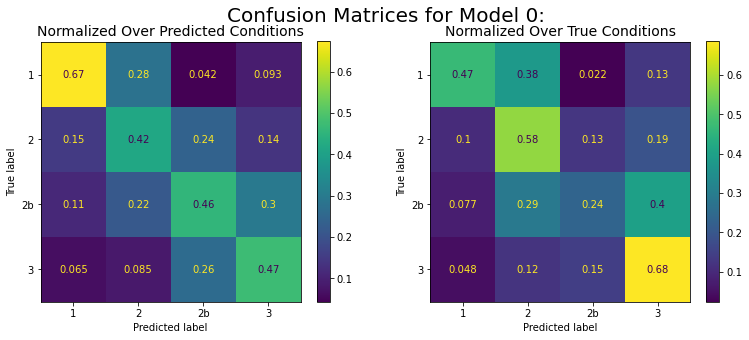

Model 1:
lr_clf mean accuracy = 0.4861878453038674
Jaccard scores by class  [0.37912088 0.32166509 0.18205128 0.38716148]
              precision    recall  f1-score   support

           1   0.671533  0.465430  0.549801       593
           2   0.419753  0.579216  0.486757       587
          2b   0.452229  0.233553  0.308026       608
           3   0.471883  0.683186  0.558207       565

    accuracy                       0.486188      2353
   macro avg   0.503849  0.490346  0.475698      2353
weighted avg   0.504115  0.486188  0.473619      2353



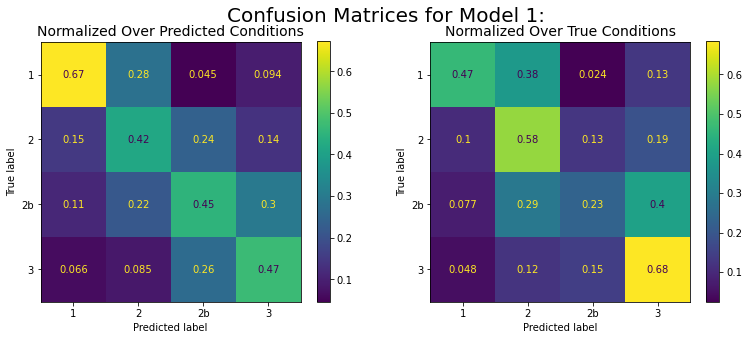

Model 2:
lr_clf mean accuracy = 0.4861878453038674
Jaccard scores by class  [0.37808219 0.32041588 0.18146718 0.3891675 ]
              precision    recall  f1-score   support

           1   0.668281  0.465430  0.548708       593
           2   0.418519  0.577513  0.485326       587
          2b   0.454839  0.231908  0.307190       608
           3   0.473171  0.686726  0.560289       565

    accuracy                       0.486188      2353
   macro avg   0.503702  0.490394  0.475378      2353
weighted avg   0.503971  0.486188  0.473270      2353



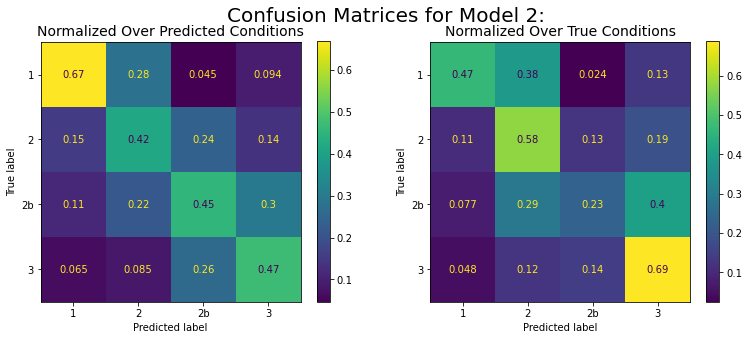

Model 3:
lr_clf mean accuracy = 0.48066298342541436
Jaccard scores by class  [0.37586685 0.32112676 0.18440594 0.37614679]
              precision    recall  f1-score   support

           1   0.679198  0.456998  0.546371       593
           2   0.417073  0.582624  0.486141       587
          2b   0.426934  0.245066  0.311390       608
           3   0.470064  0.653097  0.546667       565

    accuracy                       0.480663      2353
   macro avg   0.498317  0.484446  0.472642      2353
weighted avg   0.498406  0.480663  0.470699      2353



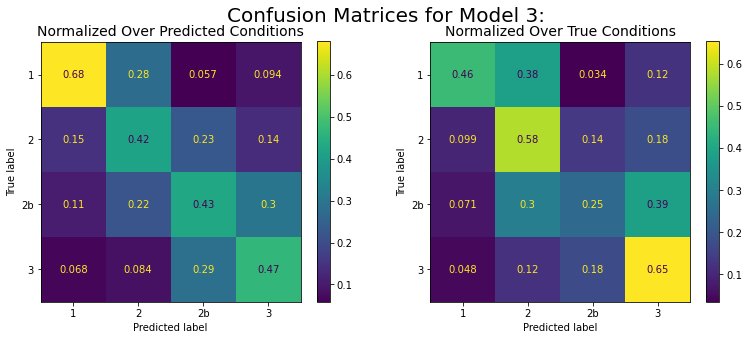

Model 4:
lr_clf mean accuracy = 0.48278793030174244
Jaccard scores by class  [0.38049451 0.32011331 0.18147685 0.38109756]
              precision    recall  f1-score   support

           1   0.672330  0.467116  0.551244       593
           2   0.418002  0.577513  0.484979       587
          2b   0.431548  0.238487  0.307203       608
           3   0.472292  0.663717  0.551876       565

    accuracy                       0.482788      2353
   macro avg   0.498543  0.486708  0.473826      2353
weighted avg   0.498634  0.482788  0.471806      2353



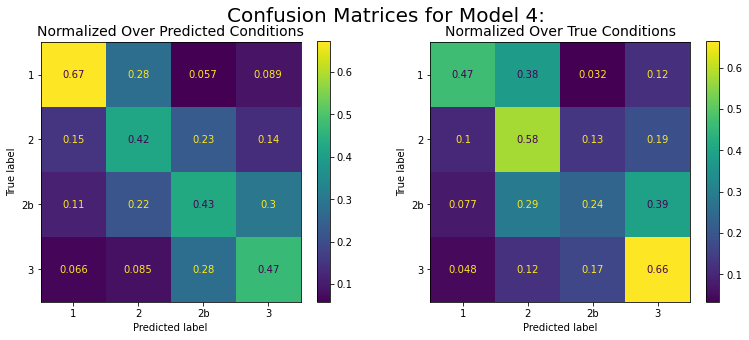

Model 5:
lr_clf mean accuracy = 0.4878878028049299
Jaccard scores by class  [0.38186813 0.32071902 0.18380463 0.38994975]
              precision    recall  f1-score   support

           1   0.673123  0.468803  0.552684       593
           2   0.419036  0.577513  0.485673       587
          2b   0.456869  0.235197  0.310532       608
           3   0.474328  0.686726  0.561099       565

    accuracy                       0.487888      2353
   macro avg   0.505839  0.492060  0.477497      2353
weighted avg   0.506123  0.487888  0.475417      2353



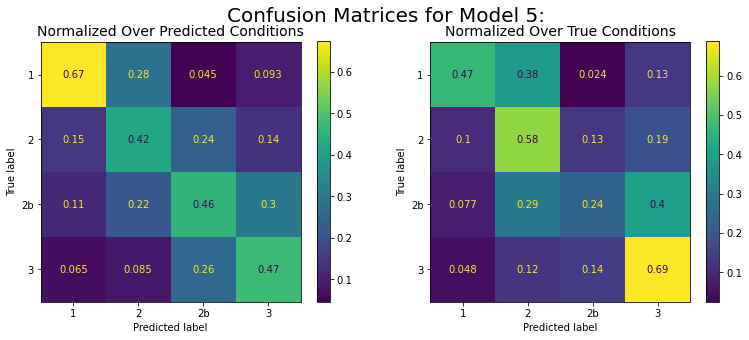

Model 6:
lr_clf mean accuracy = 0.4857628559286018
Jaccard scores by class  [0.37671233 0.32071902 0.18333333 0.3875502 ]
              precision    recall  f1-score   support

           1   0.667476  0.463744  0.547264       593
           2   0.419036  0.577513  0.485673       587
          2b   0.453968  0.235197  0.309859       608
           3   0.472460  0.683186  0.558611       565

    accuracy                       0.485763      2353
   macro avg   0.503235  0.489910  0.475352      2353
weighted avg   0.503502  0.485763  0.473280      2353



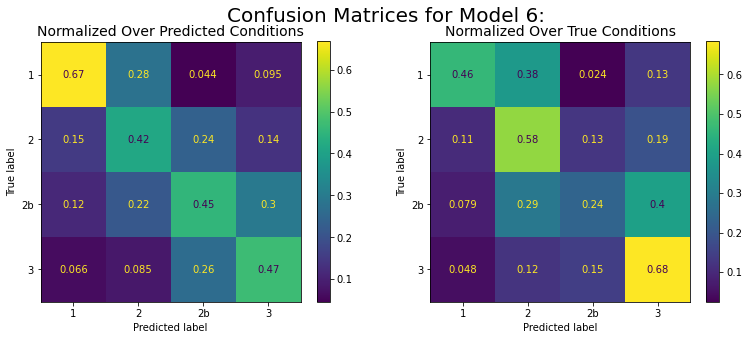

Model 7:
lr_clf mean accuracy = 0.4857628559286018
Jaccard scores by class  [0.37689133 0.32169811 0.18018018 0.38838839]
              precision    recall  f1-score   support

           1   0.671569  0.462057  0.547453       593
           2   0.418919  0.580920  0.486795       587
          2b   0.453074  0.230263  0.305344       608
           3   0.472019  0.686726  0.559481       565

    accuracy                       0.485763      2353
   macro avg   0.503895  0.489992  0.474768      2353
weighted avg   0.504167  0.485763  0.472649      2353



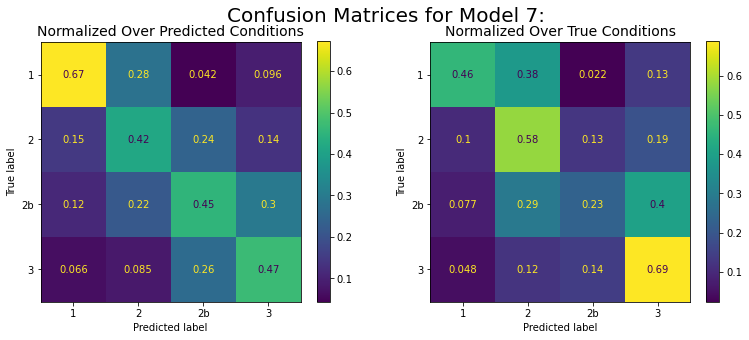

Model 8:
lr_clf mean accuracy = 0.4840628984275393
Jaccard scores by class  [0.38049451 0.3210576  0.18444166 0.38148525]
              precision    recall  f1-score   support

           1   0.672330  0.467116  0.551244       593
           2   0.418719  0.579216  0.486061       587
          2b   0.437500  0.241776  0.311441       608
           3   0.472888  0.663717  0.552283       565

    accuracy                       0.484063      2353
   macro avg   0.500359  0.487956  0.475257      2353
weighted avg   0.500494  0.484063  0.473269      2353



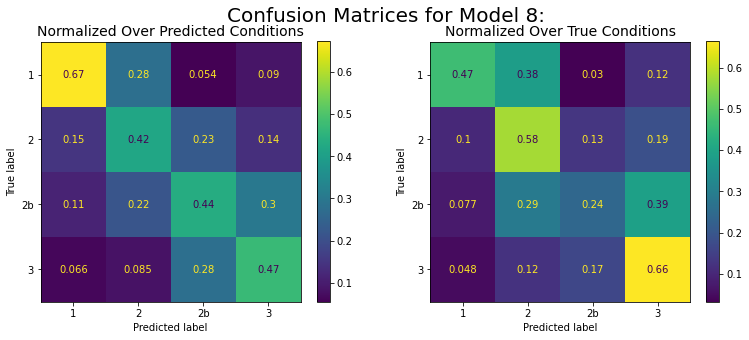

Model 9:
lr_clf mean accuracy = 0.486612834679133
Jaccard scores by class  [0.38049451 0.31988743 0.18333333 0.38905775]
              precision    recall  f1-score   support

           1   0.672330  0.467116  0.551244       593
           2   0.415854  0.580920  0.484719       587
          2b   0.453968  0.235197  0.309859       608
           3   0.476427  0.679646  0.560175       565

    accuracy                       0.486613      2353
   macro avg   0.504645  0.490720  0.476499      2353
weighted avg   0.504884  0.486613  0.474420      2353



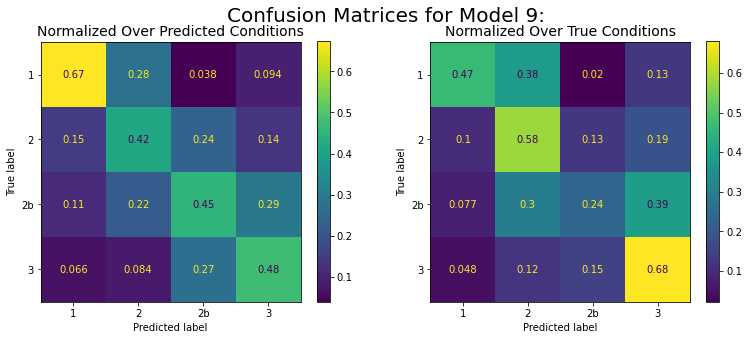

In [57]:
# For each logistic regression classifier in the cross-validation, print the Jaccard score for each class.
for index, lr_clf in zip(range(len(logistic_regression_oversampling_scores['estimator'])), logistic_regression_oversampling_scores['estimator']):
    lr_clf_score = lr_clf.score(X_test, y_test)
    y_test_predicted = lr_clf.predict(X_test)
    lr_clf_jaccard_scores = jaccard_score(y_test, y_test_predicted, average=None, labels=['1', '2', '2b', '3'])
    print('Model %d:' % (index))
    print('lr_clf mean accuracy =', lr_clf_score)
    print('Jaccard scores by class ', lr_clf_jaccard_scores)
    print(classification_report(y_test, y_test_predicted, labels=['1', '2', '2b', '3'], target_names=['1', '2', '2b', '3'], digits=6))
    
    # Create a figure.
    fig = plt.figure(num=str(index), figsize=(6.4 * 2, 4.8))
    fig.suptitle('Confusion Matrices for Model %d:' % (index), fontsize=20)
    
    ax = plt.subplot(1,2,1)
    ax.set_title("Normalized Over Predicted Conditions", fontsize=14)
    plot_confusion_matrix(lr_clf, X_test, y_test, labels=['1', '2', '2b', '3'], display_labels=['1', '2', '2b', '3'], normalize='pred', ax=ax)
    
    ax = plt.subplot(1,2,2)
    ax.set_title("Normalized Over True Conditions", fontsize=14)
    plot_confusion_matrix(lr_clf, X_test, y_test, labels=['1', '2', '2b', '3'], display_labels=['1', '2', '2b', '3'], normalize='true', ax=ax)
    
    plt.show()

In [58]:
range(len(linear_svc_oversampling_scores['estimator']))

range(0, 10)

Model 0:
linear_svc_clf mean accuracy = 0.4925626859328517
Jaccard scores by class  [0.3796034  0.3210576  0.1754386  0.40441883]
              precision    recall  f1-score   support

           1   0.703412  0.451939  0.550308       593
           2   0.418719  0.579216  0.486061       587
          2b   0.494297  0.213816  0.298507       608
           3   0.469342  0.745133  0.575923       565

    accuracy                       0.492563      2353
   macro avg   0.521443  0.497526  0.477700      2353
weighted avg   0.522151  0.492563  0.475368      2353



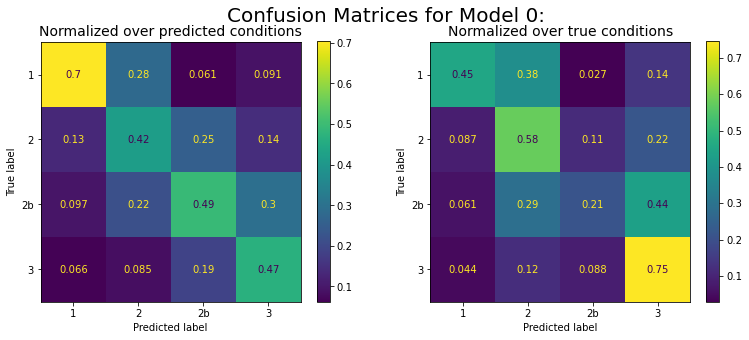

Model 1:
linear_svc_clf mean accuracy = 0.4925626859328517
Jaccard scores by class  [0.37818697 0.32166509 0.17654987 0.40403071]
              precision    recall  f1-score   support

           1   0.702632  0.450253  0.548818       593
           2   0.419753  0.579216  0.486757       587
          2b   0.494340  0.215461  0.300115       608
           3   0.468820  0.745133  0.575530       565

    accuracy                       0.492563      2353
   macro avg   0.521386  0.497516  0.477805      2353
weighted avg   0.522098  0.492563  0.475486      2353



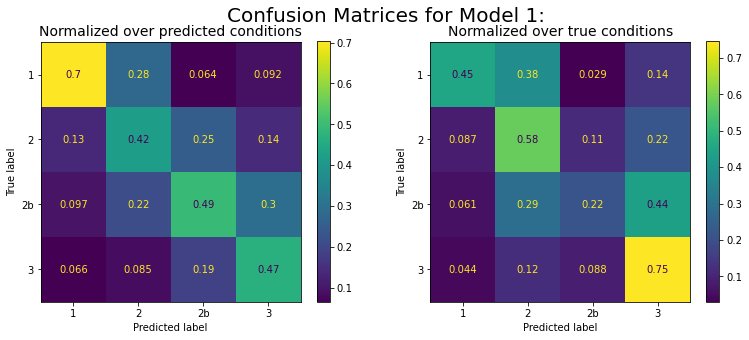

Model 2:
linear_svc_clf mean accuracy = 0.49001274968125796
Jaccard scores by class  [0.37818697 0.32200189 0.16893733 0.39943074]
              precision    recall  f1-score   support

           1   0.702632  0.450253  0.548818       593
           2   0.419434  0.580920  0.487143       587
          2b   0.496000  0.203947  0.289044       608
           3   0.462637  0.745133  0.570847       565

    accuracy                       0.490013      2353
   macro avg   0.520176  0.495063  0.473963      2353
weighted avg   0.520963  0.490013  0.471598      2353



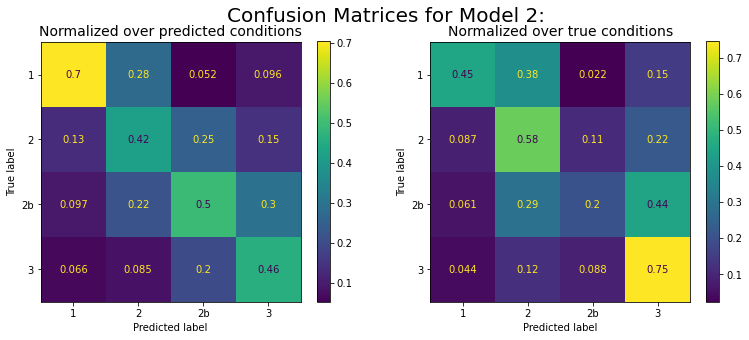

Model 3:
linear_svc_clf mean accuracy = 0.4887377815554611
Jaccard scores by class  [0.37535411 0.31981132 0.17402945 0.39884947]
              precision    recall  f1-score   support

           1   0.701058  0.446880  0.545829       593
           2   0.417488  0.577513  0.484632       587
          2b   0.483271  0.213816  0.296465       608
           3   0.465324  0.736283  0.570254       565

    accuracy                       0.488738      2353
   macro avg   0.516785  0.493623  0.474295      2353
weighted avg   0.517437  0.488738  0.471993      2353



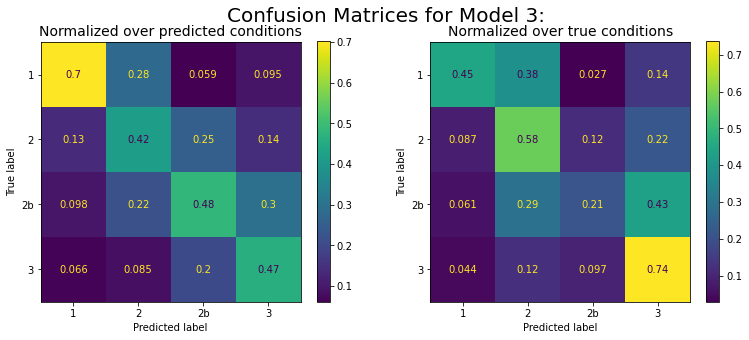

Model 4:
linear_svc_clf mean accuracy = 0.4908627284317892
Jaccard scores by class  [0.37853107 0.32041588 0.17115903 0.40364334]
              precision    recall  f1-score   support

           1   0.699739  0.451939  0.549180       593
           2   0.418519  0.577513  0.485326       587
          2b   0.486590  0.208882  0.292290       608
           3   0.468298  0.745133  0.575137       565

    accuracy                       0.490863      2353
   macro avg   0.518286  0.495867  0.475483      2353
weighted avg   0.518934  0.490863  0.473104      2353



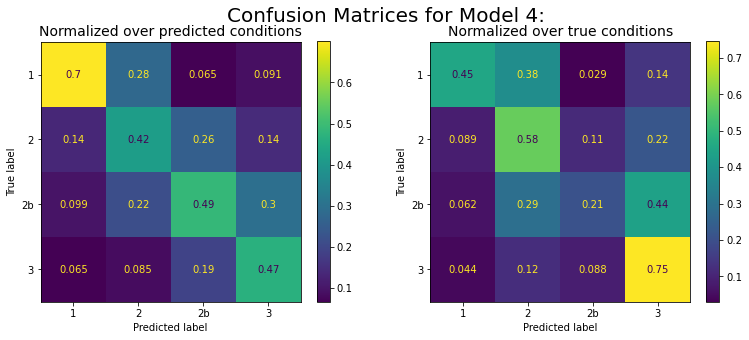

Model 5:
linear_svc_clf mean accuracy = 0.4912877178070548
Jaccard scores by class  [0.38101983 0.3210576  0.17004049 0.4032567 ]
              precision    recall  f1-score   support

           1   0.704188  0.453626  0.551795       593
           2   0.418719  0.579216  0.486061       587
          2b   0.486486  0.207237  0.290657       608
           3   0.467778  0.745133  0.574744       565

    accuracy                       0.491288      2353
   macro avg   0.519293  0.496303  0.475814      2353
weighted avg   0.519953  0.491288  0.473431      2353



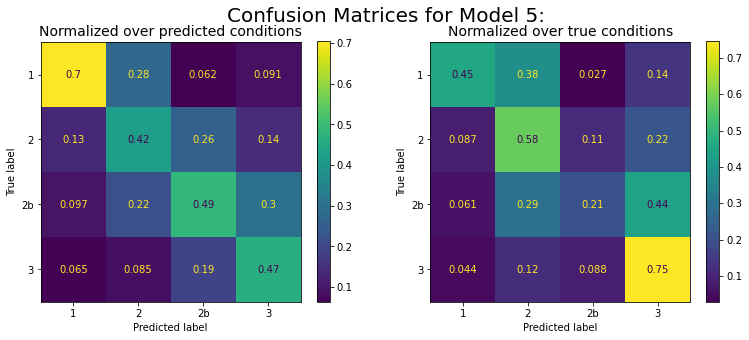

Model 6:
linear_svc_clf mean accuracy = 0.4887377815554611
Jaccard scores by class  [0.3748232  0.3194707  0.17096336 0.39943074]
              precision    recall  f1-score   support

           1   0.699208  0.446880  0.545267       593
           2   0.417800  0.575809  0.484241       587
          2b   0.494118  0.207237  0.292005       608
           3   0.462637  0.745133  0.570847       565

    accuracy                       0.488738      2353
   macro avg   0.518441  0.493765  0.473090      2353
weighted avg   0.519206  0.488738  0.470744      2353



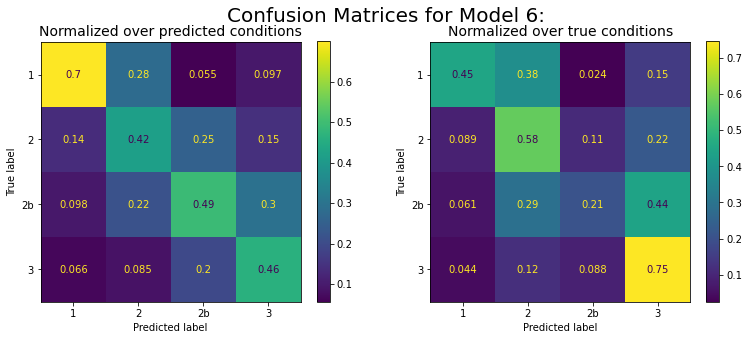

Model 7:
linear_svc_clf mean accuracy = 0.49001274968125796
Jaccard scores by class  [0.37638889 0.32015066 0.16734694 0.40444015]
              precision    recall  f1-score   support

           1   0.680905  0.456998  0.546922       593
           2   0.417178  0.579216  0.485021       587
          2b   0.492000  0.202303  0.286713       608
           3   0.470787  0.741593  0.575945       565

    accuracy                       0.490013      2353
   macro avg   0.515217  0.495028  0.473651      2353
weighted avg   0.515848  0.490013  0.471213      2353



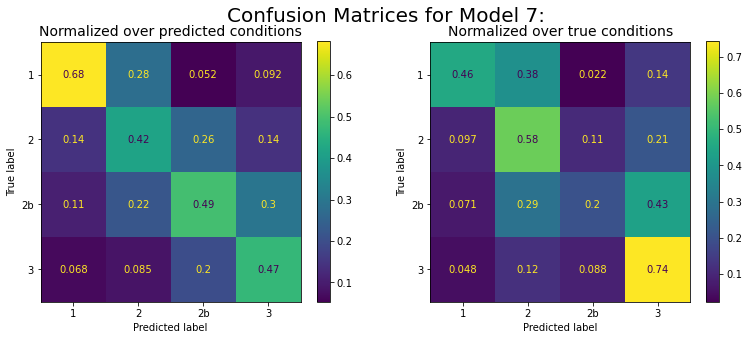

Model 8:
linear_svc_clf mean accuracy = 0.49171270718232046
Jaccard scores by class  [0.37906648 0.3204524  0.17273954 0.40480769]
              precision    recall  f1-score   support

           1   0.701571  0.451939  0.549744       593
           2   0.417690  0.579216  0.485368       587
          2b   0.490421  0.210526  0.294591       608
           3   0.469866  0.745133  0.576318       565

    accuracy                       0.491713      2353
   macro avg   0.519887  0.496704  0.476505      2353
weighted avg   0.520555  0.491713  0.474135      2353



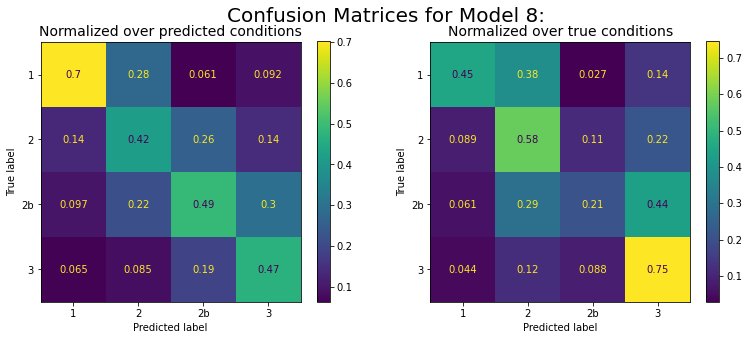

Model 9:
linear_svc_clf mean accuracy = 0.4929876753081173
Jaccard scores by class  [0.38055556 0.3204524  0.17227456 0.40900196]
              precision    recall  f1-score   support

           1   0.683292  0.462057  0.551308       593
           2   0.417690  0.579216  0.485368       587
          2b   0.486692  0.210526  0.293915       608
           3   0.477714  0.739823  0.580556       565

    accuracy                       0.492988      2353
   macro avg   0.516347  0.497906  0.477787      2353
weighted avg   0.516869  0.492988  0.475372      2353



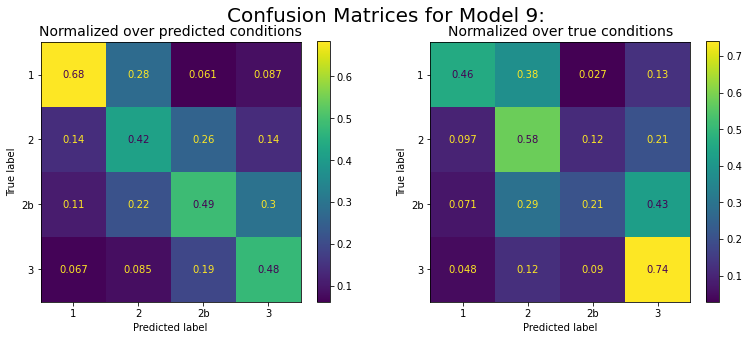

In [59]:
# For each support vector machine classifier in the cross-validation, print the Jaccard score for each class.
for index, linear_svc_clf in zip(range(len(linear_svc_oversampling_scores['estimator'])), linear_svc_oversampling_scores['estimator']):
    linear_svc_score = linear_svc_clf.score(X_test, y_test)
    y_test_predicted = linear_svc_clf.predict(X_test)
    linear_svc_jaccard_scores = jaccard_score(y_test, y_test_predicted, average=None, labels=['1', '2', '2b', '3'])
    print('Model %d:' % (index))
    print('linear_svc_clf mean accuracy =', linear_svc_score)
    print('Jaccard scores by class ', linear_svc_jaccard_scores)
    print(classification_report(y_test, y_test_predicted, labels=['1', '2', '2b', '3'], target_names=['1', '2', '2b', '3'], digits=6))

    # Create a figure.
    fig = plt.figure(num=str(index), figsize=(6.4 * 2, 4.8))
    fig.suptitle('Confusion Matrices for Model %d:' % (index), fontsize=20)
    
    ax = plt.subplot(1,2,1)
    ax.set_title("Normalized over predicted conditions", fontsize=14)
    plot_confusion_matrix(linear_svc_clf, X_test, y_test, labels=['1', '2', '2b', '3'], display_labels=['1', '2', '2b', '3'], normalize='pred', ax=ax)
    
    ax = plt.subplot(1,2,2)
    ax.set_title("Normalized over true conditions", fontsize=14)
    plot_confusion_matrix(linear_svc_clf, X_test, y_test, labels=['1', '2', '2b', '3'], display_labels=['1', '2', '2b', '3'], normalize='true', ax=ax)
    
    plt.show()

In [60]:
print('Graphics and reports generated in %f seconds' % elapsed_time(t0))

Graphics and reports generated in 51.029852 seconds


In [61]:
print_elapsed_time(notebook_start_time)

Elapsed time is 119.96117072697962 seconds.
